In [56]:
import pandas as pd
import math
import numpy as np
import queue as pythonQueue
import networkx as nx
import matplotlib 
import matplotlib.pyplot as plt
import time
import itertools
from operator import itemgetter

Definitions

In [2]:
ATTRIBUTE_NAME = 0
ATTRIBUTE_HEIGHT = 1

Import data from file

In [3]:
data = pd.read_csv('adult.data', header=0, sep=', ', engine='python' )

# Move to lowercase
data.columns = [col.lower() for col in data.columns]

Drop these columns:
- Fnlwgt
- Education-num
- Relationship
- Capital gain
- Capital loss
- Hours-per-week

In [4]:
data.drop(columns=['fnlwgt', 'education_num', 'relationship', 'capital_gain', 'capital_loss', 'hours_per_week'], inplace=True);

Drop rows in which we have unknown values ('?')

In [5]:
data.drop(data[
                (data.workclass == '?') |
                (data.education == '?') |
                (data.marital_status == '?') |
                (data.occupation == '?') |
                (data.race == '?') |
                (data.gender == '?') |
                (data.native_country == '?') |
                (data.salary == '?')].index, inplace=True);

# Domain generalization

For each remaining Q.I. and its corresponding domain, we define a generalization hierarchy, according to this (numbers in parenthesis corresponds to the height of the associated generalization hierarchy)

- Age => 5-, 10-, 20- year ranges (4)
- Workclass => Taxonomy tree (2)
- Education =>  Taxonomy tree (2)
- Marital status => Taxonomy tree (2)
- Occupation => Taxonomy tree (2)
- Race => Suppression (1)
- Gender => Suppression (1)
- Native country => Taxonomy tree (2)
- Salary => Suppression (1)

### Domain generalization for Age
- 5- year ranges
- 10- year ranges
- 20- year ranges

In [6]:
age = pd.DataFrame({'age_0' : np.sort(pd.unique(data['age']))})
age['age_1'] = (age['age_0']/5).apply(math.floor)*5
age['age_2'] = (age['age_0']/10).apply(math.floor)*10
age['age_3'] = (age['age_0']/20).apply(math.floor)*20

### Domain generalization for Workclass

- Private => Private => Working
- Self-emp-not-inc => Self-Emp => Working
- Self-emp-inc => Self-Emp => Working
- Federal-gov => Federal-gov => Working
- Local-gov => Other-gov => Working
- State-gov => Other-gov => Working
- Without-pay => Not-Working => Not-Working
- Never-worked => Not-Working => Not-Working

In [7]:
workclass = pd.DataFrame({'workclass_0' : np.sort(pd.unique(data['workclass']))})

workclass['workclass_1'] = workclass['workclass_0']
workclass['workclass_1'].where(workclass['workclass_1'] != 'Self-emp-inc', 'Self-Emp', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Self-emp-not-inc', 'Self-Emp', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Local-gov', 'Other-gov', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'State-gov', 'Other-gov', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Never-worked', 'Not-Working', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Without-pay', 'Not-Working', inplace=True)

workclass['workclass_2'] = workclass['workclass_1']
workclass['workclass_2'].where(workclass['workclass_2'] != 'Self-Emp', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Federal-gov', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Other-gov', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Private', 'Working', inplace=True)

### Domain generalization for Education

- "^10th" => "Dropout" => "Low"

- "^11th" => "Dropout" => "Low"

- "^12th" => "Dropout" => "Low"

- "^1st-4th" => "Dropout" => "Low"

- "^5th-6th" => "Dropout" => "Low"

- "^7th-8th" => "Dropout" => "Low"

- "^9th" => "Dropout" => "Low"

- "^Preschool" => "Dropout" => "Low"

- "^Assoc-acdm" => "Associates" => "High"

- "^Assoc-voc" => "Associates" => "High"

- "^Bachelors" => "Bachelors" => "High"

- "^Doctorate" => "Doctorate" => "High"

- "^HS-Grad" => "HS-Graduate" => "High"

- "^Masters" => "Masters" => "High"

- "^Prof-school" => "Prof-School" => "High"

- "^Some-college" => "HS-Graduate" => "High"


In [8]:
education = pd.DataFrame({'education_0' : np.sort(pd.unique(data['education']))})

education['education_1'] = education['education_0']
education['education_1'].where(education['education_1'] != '10th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '11th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '12th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '1st-4th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '5th-6th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '7th-8th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '9th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != 'Preschool', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != 'Assoc-voc', 'Associates', inplace=True)
education['education_1'].where(education['education_1'] != 'Assoc-acdm', 'Associates', inplace=True)
education['education_1'].where(education['education_1'] != 'HS-grad', 'HS-Graduate', inplace=True)
education['education_1'].where(education['education_1'] != 'Some-college', 'HS-Graduate', inplace=True)

education['education_2'] = education['education_1']
education['education_2'].where(education['education_2'] != 'Dropout', 'Low', inplace=True)
education['education_2'].where(education['education_2'] != 'Prof-school', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Associates', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Bachelors', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Masters', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'HS-Graduate', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Doctorate', 'High', inplace=True)

### Domain generalization for Marital status

- Widowed => Widowed => Married
- Divorced => Not-Married => Not-Married
- Married-AF-spouse => Married => Married
- Separated => Not-Married => Not-Married
- Married-spouse-absent => Not-Married => Not-Married
- Married-civ-spouse => Married => Married
- Never-married => Never-Married => Not-Married

In [9]:
marital_status = pd.DataFrame({'marital_status_0' : np.sort(pd.unique(data['marital_status']))})

marital_status['marital_status_1'] = marital_status['marital_status_0']
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Divorced', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-AF-spouse', 'Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Separated', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-spouse-absent', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-civ-spouse', 'Married', inplace=True)

marital_status['marital_status_2'] = marital_status['marital_status_1']
marital_status['marital_status_2'].where(marital_status['marital_status_2'] != 'Widowed', 'Married', inplace=True)
marital_status['marital_status_2'].where(marital_status['marital_status_2'] != 'Never-married', 'Not-Married', inplace=True)

### Domain generalization for Occupation
- Adm-clerical => Admin => A
- Armed-Forces => Military => A
- Craft-repair => Blue-Collar => B
- Exec-managerial => White-Collar => A
- Farming-fishing => Blue-Collar => B
- Handlers-cleaners => Blue-Collar => B
- Machine-op-inspct => Blue-Collar => B
- Other-service => Service => B
- Priv-house-serv => Service => B
- Prof-specialty => Other-Occupations => A
- Protective-serv => Other-Occupations => A
- Sales => Sales => B
- Tech-support => Other-Occupations => A
- Transport-moving => Other-Occupations => A

In [10]:
occupation = pd.DataFrame({'occupation_0' : np.sort(pd.unique(data['occupation']))})

occupation['occupation_1'] = occupation['occupation_0']
occupation['occupation_1'].where(occupation['occupation_1'] != 'Adm-clerical', 'Admin', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Armed-Forces', 'Military', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Craft-repair', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Exec-managerial', 'White-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Farming-fishing', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Handlers-cleaners', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Machine-op-inspct', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Other-service', 'Service', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Priv-house-serv', 'Service', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Prof-specialty', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Protective-serv', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Tech-support', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Transport-moving', 'Other-Occupations', inplace=True)

occupation['occupation_2'] = occupation['occupation_1']
occupation['occupation_2'].where(occupation['occupation_2'] != 'Military', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Sales', 'B', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Admin', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'White-Collar', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Other-Occupations', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Service', 'B', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Blue-Collar', 'B', inplace=True)

### Domain generalization for Race
Based on suppression

In [11]:
race = pd.DataFrame({'race_0' : np.sort(pd.unique(data['race']))})

race['race_1'] = race['race_0']
race['race_1'].where(race['race_1'] != race['race_1'], '*', inplace=True)

### Domain generalization for Gender

Based on suppression

In [12]:
gender = pd.DataFrame({'gender_0' : np.sort(pd.unique(data['gender']))})

gender['gender_1'] = gender['gender_0']
gender['gender_1'].where(gender['gender_1'] != gender['gender_1'], '*', inplace=True)

### Domain generalization for Native Country

- Cambodia => SE-Asia => Asia
- Canada => British-Commonwealth => British-Commonwealth   
- China => Asia => Asia
- Columbia => South-America => South-America
- Cuba => Latin-America => South-America
- Dominican-Republic => Latin-America => South-America
- Ecuador => South-America => South-America
- El-Salvador => South-America => South-America
- England => British-Commonwealth => British-Commonwealth
- France => Euro_1 => Europe
- Germany => Euro_1 => Europe
- Greece => Euro_2 => Europe
- Guatemala => Latin-America => South-America
- Haiti => Latin-America => South-America
- Holand-Netherlands => Euro_1 => Europe
- Honduras => Latin-America => South-America
- Hong => Asia => Asia
- Hungary => Euro_2 => Europe
- India => British-Commonwealth => British-Commonwealth
- Iran => Asia => Asia
- Ireland => British-Commonwealth => British-Commonwealth
- Italy => Euro_1 => Europe
- Jamaica => Latin-America => South-America
- Japan => Asia => Asia
- Laos => SE-Asia => Asia
- Mexico => Latin-America => South-America
- Nicaragua => Latin-America => South-America
- Outlying-US(Guam-USVI-etc) => Latin-America => South-America
- Peru => South-America => South-America
- Philippines => SE-Asia => Asia
- Poland => Euro_2 => Europe
- Portugal => Euro_2 => Europe
- Puerto-Rico => Latin-America => South-America
- Scotland => British-Commonwealth => British-Commonwealth
- South => Euro_2 => Europe
- Taiwan => Asia => Asia
- Thailand => SE-Asia => Asia
- Trinadad&Tobago => Latin-America => South-America
- United-States => United-States => United-States
- Vietnam => SE-Asia => Asia
- Yugoslavia => Euro_2 => Europe

In [13]:
native_country = pd.DataFrame({'native_country_0' : np.sort(pd.unique(data['native_country']))})

native_country['native_country_1'] = native_country['native_country_0']

native_country['native_country_1'].where(native_country['native_country_1'] != 'Cambodia', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Canada', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'China', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Columbia', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Cuba', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Dominican-Republic', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Ecuador', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'El-Salvador', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'England', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'France', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Germany', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Greece', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Guatemala', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Haiti', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Holand-Netherlands', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Honduras', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Hong', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Hungary', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'India', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Iran', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Ireland', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Italy', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Jamaica', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Japan', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Laos', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Mexico', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Nicaragua', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Outlying-US(Guam-USVI-etc)', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Peru', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Philippines', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Poland', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Portugal', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Puerto-Rico', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Scotland', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'South', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Taiwan', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Thailand', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Trinadad&Tobago', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Vietnam', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Yugoslavia', 'Euro_2', inplace=True)

native_country['native_country_2'] = native_country['native_country_1']
native_country['native_country_2'].where(native_country['native_country_2'] != 'Euro_1', 'Europe', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'Euro_2', 'Europe', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'SE-Asia', 'Asia', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'Latin-America', 'South-America', inplace=True)

### Domain generalization for Salary

Based on suppression

In [14]:
salary = pd.DataFrame({'salary_0' : np.sort(pd.unique(data['salary']))})

salary['salary_1'] = salary['salary_0']
salary['salary_1'].where(salary['salary_1'] != salary['salary_1'], '*', inplace=True)

### Domains to array

In [15]:
dimensions = {}
dimensions['age']=age
dimensions['workclass'] = workclass
dimensions['education']=education
dimensions['marital_status']=marital_status
dimensions['occupation']=occupation
dimensions['race']=race
dimensions['gender']=gender
dimensions['native_country']=native_country
dimensions['salary']=salary
#data_concat = data

data_concat = pd.DataFrame()
for dimension in dimensions:
    data_concat = pd.concat([data_concat, dimensions[dimension]], axis=1)

### Graph utilities

### Graph definition
Each node of the graph is a generalization. A node is a tuple of tuples (tuple_1, tuple_2, ..., tuple_n).
Each tuple_i is composed as (Attribute_name, Attribute_generalization).
Ex. (('Age', 0), ('Sex', 0)) is a generalization with respect to columns age_0, sex_0

In [16]:
def generate_graph_0(Q, dimensions):
    G = nx.DiGraph()
    for dimension_name in Q:
        prev = None
        height = 0
        for _ in dimensions[dimension_name].columns:
            l = [(dimension_name, height)]
            #Convert the list to tuple to make it hashable
            current_node = tuple(l)
            
            if prev is not None:
                #from ((age, 0)) to ((age, 1)), then ((age,1)) to ((age, 2))
                G.add_edge(prev, current_node)
                
            height = height + 1
            prev = current_node
    
    return G

In [17]:
def printGraph(G):
    #print("G nodes:")
    for node in G.nodes():
        print(node)

def plotGraph(G):
    labels = {node:str(node) for node in G.nodes()}
    plt.figure(figsize=(15,8))
    nx.draw(G, with_labels=True, labels=labels)
    plt.plot()            

# Incognito algorithm

In [18]:
def difference(A, B):
    result = sorted([item for item in A if item not in B])
    return tuple(result)

def sortAlphaTup(tup):
    x = ""
    for i in range(0, len(tup)):
        x += str(tup[i][0])
    return x

In [19]:
def frequencySet_standard(T, Q, generalizations):
    # Add each name of attribute in T the level _0 since it is level 0 generalization:
    #  this way it can easily use the groupby   
    tmpT = T.copy()
    tmpT.columns = [str(col) + '_0' for col in tmpT.columns]
    
    #print("Asked fset of T", tmpT.columns, "on Q", Q)
    
    for attribute in Q:
        #Extract generalization height from string
        attribute_height = int(attribute[len(attribute)-1])
        #print("attr height", attribute_height)
        
        # If it is not level 0 generalization, join with the corresponding dimension table
        # It will never happen that in Q there will be two level of the same domain, i dont need to control it
        if not attribute_height == 0:
            attribute_name = attribute[:len(attribute)-2]
            #print("attr name", attribute_name)
            # find corresponding height of this attribute in T
            for t_col in tmpT.columns:
                if t_col[:len(t_col)-2] == attribute_name:
                    correspondingHeightInT = int(t_col[len(t_col)-1])

            tmpT = tmpT.set_index(attribute_name+'_'+str(correspondingHeightInT))\
            .join(generalizations[attribute_name][[attribute_name+'_'+str(attribute_height),
                                                          attribute_name+'_'+str(correspondingHeightInT)]].drop_duplicates()\
                          .set_index(attribute_name+'_'+str(correspondingHeightInT)))
            
    if (len(tmpT.columns) == len(Q)):
        tmpT['RandomColumn'] = tmpT.iloc[:,:1]
        
    fsSet = tmpT.groupby(Q).count().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    fsSet.rename({fsSet.columns[(len(Q))] : 'Count'}, axis='columns', inplace=True)
    
    return fsSet

In [20]:
def frequencySet_fromParent(T, Q, generalizations):
    #print("Asked fset of T", T.columns, "on Q", Q)
    
    tmpT = T.copy()
    
    for attribute in Q:
        #Extract generalization height from string
        attribute_height = int(attribute[len(attribute)-1])
        # If it is not level 0 generalization, join with the corresponding dimension table
        # It will never happen that in Q there will be two level of the same domain, i dont need to control it
        if not attribute_height == 0:
            attribute_name = attribute[:len(attribute)-2]
            # find corresponding height of this attribute in T
            for t_col in tmpT.columns:
                if t_col[:len(t_col)-2] == attribute_name:
                    correspondingHeightInT = int(t_col[len(t_col)-1])
            
            
            if not correspondingHeightInT == attribute_height:
            
                tmpT = pd.merge(tmpT, generalizations[attribute_name][[attribute_name+'_'+str(attribute_height),
                                                          attribute_name+'_'+str(correspondingHeightInT)]].drop_duplicates(),
                               on=attribute_name+'_'+str(correspondingHeightInT))\
                .drop(labels=attribute_name+'_'+str(correspondingHeightInT), axis=1)
                
    fsSet = tmpT.groupby(Q)['Count'].sum().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    return fsSet

In [21]:
def frequencySet_fromParent_cube(T, Q):
    # T is already a frequencySet, Q is a list of attributes
    # CONSTRAINT: Q must have #columns = (#columns of T - 1) and all the columns in Q must be in T, T must have Count column
    tmpT = T.copy() 
    fsSet = T.groupby(Q)['Count'].sum().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    return fsSet

In [22]:
def computeK(frequencySet):
    return min(frequencySet['Count'])

#### Generate attributes list.  For each attribute, include all its generalizations. 
Ex. if current node is age_1, we shoud group by age_1, age_2 and age_3 because the latter ones will be needed in next iterations in parentFrequencySet. Of course group by(age_1) has the same number of rows of group by (age_1, age_2, age_3)

In [23]:
def getAllAttributesGeneralizations(node, generalizations):
    attributesOfNode = list()
    for attribute in list(node):
            attributeGeneralizaiton = generalizations[attribute[ATTRIBUTE_NAME]]
            
            for i in range(attribute[ATTRIBUTE_HEIGHT], len(attributeGeneralizaiton.columns)):
                attributesOfNode.append("{}_{}".format(attribute[ATTRIBUTE_NAME], i))
                
    return attributesOfNode

In [24]:
def getNodeAttributes(node):
    attributesOfNode = list()
    for attribute in node:
        attributesOfNode.append("{}_{}".format(attribute[ATTRIBUTE_NAME], attribute[ATTRIBUTE_HEIGHT]))
    return attributesOfNode

In [25]:
def getNodeHeight(node):
        height = 0
        for nodeAttr in node:
            #print(nodeAttr, "is attribute of ", node)
            height = height + nodeAttr[ATTRIBUTE_HEIGHT]
        return height

In [26]:
def fromListToNode(L):
    attributeList = list()
    for element in L:
        attribute_height = int(element[len(element)-1])
        attribute_name = element[:len(element)-2]
        attributeList.append((attribute_name, attribute_height))
    return tuple(attributeList)

In [27]:
def generateGraph(C_i):
    G = nx.DiGraph()
    new_edges = pd.DataFrame()
    df = pd.DataFrame(list(C_i.nodes()))
    num_columns = len(df.columns)
    
    last_x = str(num_columns-1)+'_x'
    last_y = str(num_columns-1)+'_y'
    if (num_columns > 1):
        
        df_key = df.copy()
        df_key = df_key.drop(columns=[num_columns-1])
        df_key = df_key.apply(tuple, axis=1)
        
        df_parent = df.copy()
        df_parent = df_parent.apply(tuple, axis=1)
                
        df2 = df.copy()

        df['key'] = df_key
        df2['key'] = df_key
        df['parent_x'] = df_parent #list(zip(df['key'], df[last_x]))
        df2['parent_y'] = df_parent #list(zip(df2['key'], df2[last_y]))
        nodes = df.merge(df2, on='key', how='inner')
        nodes = nodes[['key', str(num_columns-1)+'_x', str(num_columns-1)+'_y', 'parent_x', 'parent_y']]
        nodes2 = pd.DataFrame()
        for index, row in nodes.iterrows():
            if (row[last_x][0] < row[last_y][0]):
                nodes2 = nodes2.append(row)
                #l = [row['key'], row[last_x], row[last_y]]
                l = row['parent_x'] + tuple([row[last_y]])
                G.add_node(l)
        nodes2 = nodes2.reset_index(drop=True) 
    else:
        df['key'] = 0
        df2 = df.copy()
        nodes = df.merge(df2, on='key', how='outer')
        nodes2 = pd.DataFrame()
        for index, row in nodes.iterrows():
            if (row['0_x'][0] < row['0_y'][0]):
                nodes2 = nodes2.append(row)
                l = [row['0_x'], row['0_y']]
                G.add_node(tuple(l))
        
        nodes2 = nodes2.reset_index(drop=True)
    
    edges = pd.DataFrame()
    for a, b in C_i.edges():
        if (num_columns) > 1:
            edges = edges.append({'start': a, 'end': b}, ignore_index=True)
        else:
            edges = edges.append({'start': a[0], 'end': b[0]}, ignore_index=True)
    if len(edges) == 0:
        return G
    for i, node in nodes2.iterrows():
        if (i >= 0):
            if node['key'] != 0:
                cond1_1 = edges[edges['start'] == node['parent_x']].reset_index(drop=True)
                cond1_2 = edges[edges['start'] == node['parent_y']].reset_index(drop=True)
            else:
                cond1_1 = edges[edges['start'] == node[last_x]].reset_index(drop=True)
                cond1_2 = edges[edges['start'] == node[last_y]].reset_index(drop=True)
            if node['key'] == 0:
                if len(cond1_1) > 0:
                    cond2 = nodes2[nodes2[last_x] == cond1_1['end'][0]]
                    cond2 = cond2[cond2[last_y] == node[last_y]].reset_index(drop=True)
                    if len(cond2) > 0 and node[last_y] == cond2[last_y][0] and node[last_x] != cond2[last_x][0]:
                        n1 = [node[last_x], node[last_y]]
                        n2 = [cond2[last_x][0], cond2[last_y][0]]
                        G.add_edge(tuple(n1), tuple(n2))

                if len(cond1_2) > 0:
                    cond3 = nodes2[nodes2[last_y] == cond1_2['end'][0]]
                    cond3 = cond3[cond3[last_x] == node[last_x]].reset_index(drop=True)
                    if len(cond3) > 0 and node[last_x] == cond3[last_x][0] and node[last_y] != cond3[last_y][0]:
                        n1 = [node[last_x], node[last_y]]
                        n2 = [cond3[last_x][0], cond3[last_y][0]]
                        G.add_edge(tuple(n1), tuple(n2))
            else:
                cond1 = pd.DataFrame()
                cond1_1aux = cond1_1.copy()
                cond1_1aux = cond1_1aux.rename(columns={'end': 'parent_x'})
                condaux = nodes2.merge(cond1_1aux, on='parent_x', how='inner')
                cond2aux = condaux[condaux['parent_y'] == node['parent_y']].reset_index(drop=True)
                for j in range(0, len(cond2aux)):
                    n1 = node['parent_x'] + tuple([node[last_y]])
                    n2 = cond2aux['parent_x'][j] + tuple([cond2aux[last_y][j]])
                    #G.add_edge(tuple(n1), tuple(n2))
                    new_edges = new_edges.append({'start': n1, 'end': n2}, ignore_index=True)
                
                cond1_2aux = cond1_2.copy()
                cond1_2aux = cond1_2aux.rename(columns={'end': 'parent_y'})
                condaux2 = nodes2.merge(cond1_2aux, on='parent_y', how='inner')
                cond3aux = condaux2[condaux2['parent_x'] == node['parent_x']].reset_index(drop=True)
                for j in range(0, len(cond3aux)):
                    n1 = node['parent_x'] + tuple([node[last_y]])
                    n2 = cond3aux['parent_x'][j] + tuple([cond3aux[last_y][j]])
                    #G.add_edge(tuple(n1), tuple(n2))
                    new_edges = new_edges.append({'start': n1, 'end': n2}, ignore_index=True)
                
                condaux2 = condaux2[['parent_x', 'parent_y']]
                cond1 = condaux.merge(condaux2, on=['parent_x', 'parent_y'], how='inner')
                for j in range(0, len(cond1)):
                    n1 = node['parent_x'] + tuple([node[last_y]])
                    n2 = cond1['parent_x'][j] + tuple([cond1[last_y][j]])
                    new_edges = new_edges.append({'start': n1, 'end': n2}, ignore_index=True)
               
    if len(new_edges) >0:
        remove_edges = new_edges.copy()
        remove_edges = remove_edges.rename(columns={'end': 'end2'})
        remove_edges = remove_edges.rename(columns={'start': 'end'})
        remove_edges = remove_edges.merge(new_edges, on='end', how='inner')
        remove_edges = remove_edges.drop(columns=['end'])
        remove_edges = remove_edges.rename(columns={'end2': 'end'})
        common = new_edges.merge(remove_edges,on=['start','end'])
        new_edges = pd.concat([new_edges, common]).drop_duplicates(keep=False)
        for index, edge in new_edges.iterrows():
            G.add_edge(tuple(edge['start']), tuple(edge['end']))

    #printGraph(G)

    return G

In [28]:
def incognito_standard (k, T, Q, generalizations):
    
    queue = pythonQueue.PriorityQueue()
    
    # Must be initialized outside the for since will be both shared between iterations...
    C_i = generate_graph_0(Q, generalizations) # Graph (C_i, E_i) at iteration i
    S_i = None
    sink = list((node for node, out_degree in C_i.out_degree() if out_degree == 0))[0]
    frequencySetDictionary = {}
    
    for i in range(0, len(Q)):
        # It is not a problem if we copy the whole graph instead of copying
        #  only the nodes since every time we use S_i we delete nodes, and
        #  therefore we also delete edges attached to these nodes
        S_i = C_i.copy()
        marked = set()

        # Insert all roots node into queue, keeping queue sorted by height
        for node in C_i.nodes():
            if C_i.in_degree(node) == 0:
                height = getNodeHeight(node)
                # First parameter is height, second is data
                queue.put((height, node))
        
        while not queue.empty():
            height, node = queue.get()
            
            if node not in marked and node in S_i.nodes():
                attributesOfNode = getNodeAttributes(node)
                # if node was initally a root
                if C_i.in_degree(node) == 0:
                    frequencySet = frequencySet_standard(T, attributesOfNode, generalizations)
                else:
                    frequencySetParent = frequencySetDictionary[node]
                    frequencySet = frequencySet_fromParent(frequencySetParent, attributesOfNode, generalizations)
                                        
                actual_k = computeK(frequencySet)

                # If T is k-anonymous with respect to attributes of node
                if (actual_k >= k):
                    # mark all direct generalizations of node
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            #print("marked node", pathNode)
                            marked.add(pathNode)
                else:
                    # Set childs frequency set to this one                    
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            if not pathNode == node: 
                                frequencySetDictionary[pathNode] = frequencySet
                                height = getNodeHeight (pathNode)
                                queue.put((height, pathNode))
                            
                    S_i.remove_node(node)
                    
        C_i = generateGraph(S_i)
    return S_i

In [29]:
def incognito_super_root (k, T, Q, generalizations):
    queue = pythonQueue.PriorityQueue()
    
    # Must be initialized outside the for since will be both shared between iterations...
    C_i = generate_graph_0(Q, generalizations) # Graph (C_i, E_i) at iteration i
    S_i = None
    sink = list((node for node, out_degree in C_i.out_degree() if out_degree == 0))[0]
    frequencySetDictionary = {}
    
    for z in range(0, len(Q)):
        # It is not a problem if we copy the whole graph instead of copying
        #  only the nodes since every time we use S_i we delete nodes, and
        #  therefore we also delete edges attached to these nodes
        S_i = C_i.copy()
        marked = set()

        #set containing roots
        rootSet = set()
        
        # Insert all roots node into queue, keeping queue sorted by height
        for node in C_i.nodes():
            if C_i.in_degree(node) == 0:
                # Order the content of nodes and add it to rootSet
                rootSet.add(tuple(sorted(node)))
                height = getNodeHeight(node)
                # First parameter is height, second is data
                queue.put((height, node))
        
        # Order also list of nodes in rootSet
        rootSet = sorted(rootSet, key=lambda tup: sortAlphaTup(tup))
        
        # Given a set of roots, try to find if there are common ancestors of some of them and compute freqSet at level 0
        familyFound = False
        familyCount = 0 
        
        if (len(rootSet) == 1):
            frequencySetDictionary[rootSet[0]] = frequencySet_standard(T, getNodeAttributes(rootSet[0]), generalizations)
        else:
            for i in range(1, len(rootSet)):
                sameFamilyAsBefore = True

                # If nodes contain tuples of different length then they don't come from the same family 
                if not (len(rootSet[i]) == len(rootSet[i-1])):
                    sameFamilyAsBefore = False    
                else:
                    # If nodes have tuples of the same length, then check if they have the same attributes
                    for j in range(0, len(rootSet[i])):
                        if not (rootSet[i-1][j][0] == rootSet[i][j][0]):
                            sameFamilyAsBefore = False

                # If current node has the same attributes as the one before, then add 1 to the number of members in the family
                if sameFamilyAsBefore:
                    familyFound = True
                    familyCount +=1
                    
                    # If current node is also the last one to be analyzed, then it is the last one in the family => compute freqSet
                    if (i == (len(rootSet)-1)):
                        familyAttributes = list()
                        for l in range(len(rootSet[i-1])):
                            familyAttributes.append(str(rootSet[i-1][l][ATTRIBUTE_NAME]) + "_0")

                        familyFreqSet = frequencySet_standard(T, familyAttributes, generalizations)

                        for l in range((i - familyCount), (i+1)):
                            frequencySetDictionary[rootSet[l]] = frequencySet_fromParent(familyFreqSet, getNodeAttributes(rootSet[l]), dimensions)
                
                # If current node doesnt have the same attributes of the one before:
                else:
                    # If we had found a family, then compute freqSet (until the previous node in the list)
                    if familyFound:
                        familyCount += 1
                        familyAttributes = list()
                        for l in range(len(rootSet[i-1])):
                            familyAttributes.append(str(rootSet[i-1][l][ATTRIBUTE_NAME]) + "_0")

                        familyFreqSet = frequencySet_standard(T, familyAttributes, generalizations)

                        for l in range((i - familyCount), (i)):
                            frequencySetDictionary[rootSet[l]] = frequencySet_fromParent(familyFreqSet, getNodeAttributes(rootSet[l]), dimensions)
                            
                    else:
                        frequencySetDictionary[rootSet[i-1]] = frequencySet_standard(T, getNodeAttributes(rootSet[i-1]), generalizations)

                        if (i == (len(rootSet)-1)):
                            frequencySetDictionary[rootSet[i]] = frequencySet_standard(T, getNodeAttributes(rootSet[i]), generalizations)
                                                        
                    familyFound = False
                    familyCount = 0
                
        while not queue.empty():
            height, node = queue.get()
            if node not in marked and node in S_i.nodes():
                attributesOfNode = getNodeAttributes(node)
                # if node was initally a root
                if C_i.in_degree(node) == 0:
                    frequencySet = frequencySetDictionary[node]
                else:
                    frequencySetParent = frequencySetDictionary[node]
                    frequencySet = frequencySet_fromParent(frequencySetParent, attributesOfNode, generalizations)
                    
                actual_k = computeK(frequencySet)
                
                # If T is k-anonymous with respect to attributes of node
                if (actual_k >= k):
                    # mark all direct generalizations of node
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            marked.add(pathNode)
                else:
                    # Set childs frequency set to this one                    
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            if not pathNode == node: 
                                frequencySetDictionary[pathNode] = frequencySet
                                height = getNodeHeight (pathNode)
                                queue.put((height, pathNode))
                            
                    S_i.remove_node(node)
                    
                    
        C_i = generateGraph(S_i)
    return S_i    

In [30]:
def cube_incognito (k, T, Q, generalizations):
    queue = pythonQueue.PriorityQueue()
    
    # Must be initialized outside the for since will be both shared between iterations...
    C_i = generate_graph_0(Q, generalizations) # Graph (C_i, E_i) at iteration i
    S_i = None
    sink = list((node for node, out_degree in C_i.out_degree() if out_degree == 0))[0]
    frequencySetDictionary = {}
    
    cubeQ_top = sorted([str(attribute) + '_0' for attribute in Q])
    frequencySetDictionary[fromListToNode(cubeQ_top)] = frequencySet_standard(T, getNodeAttributes(fromListToNode(cubeQ_top)), generalizations)
        
    for i in range(len(Q)-1, 0, -1):
        cubeQ_list = list(itertools.combinations(cubeQ_top, i))
        for cubeQ in cubeQ_list:
            tempDiff = list()
            tempDiff.append(difference(cubeQ_top, cubeQ)[0])
            cubeQ_tmp = sorted(cubeQ + tuple(tempDiff))
            frequencySetDictionary[fromListToNode(cubeQ)] = frequencySet_fromParent_cube(frequencySetDictionary[fromListToNode(cubeQ_tmp)], cubeQ)
    
    for z in range(0, len(Q)):
        # It is not a problem if we copy the whole graph instead of copying
        #  only the nodes since every time we use S_i we delete nodes, and
        #  therefore we also delete edges attached to these nodes
        S_i = C_i.copy()
        marked = set()

        #set containing roots
        rootSet = set()
        
        # Insert all roots node into queue, keeping queue sorted by height
        for node in C_i.nodes():
            if C_i.in_degree(node) == 0:
                # Order the content of nodes and add it to rootSet
                rootSet.add(tuple(sorted(node)))
                height = getNodeHeight(node)
                # First parameter is height, second is data
                queue.put((height, node))
        
        # Order also list of nodes in rootSet
        rootSet = sorted(rootSet, key=lambda tup: sortAlphaTup(tup))
        
        # Given a set of roots, try to find if there are common ancestors of some of them and compute freqSet at level 0
        familyFound = False
        familyCount = 0 
        
        if (len(rootSet) == 1):
            frequencySetDictionary[rootSet[0]] = frequencySet_standard(T, getNodeAttributes(rootSet[0]), generalizations)
        else:
            for i in range(1, len(rootSet)):
                sameFamilyAsBefore = True

                # If nodes contain tuples of different length then they don't come from the same family                 
                if not (len(rootSet[i]) == len(rootSet[i-1])):
                    sameFamilyAsBefore = False    
                else:
                    # If nodes have tuples of the same length, then check if they have the same attributes
                    for j in range(0, len(rootSet[i])):
                        if not (rootSet[i-1][j][0] == rootSet[i][j][0]):
                            sameFamilyAsBefore = False

                # If current node has the same attributes as the one before, then add 1 to the number of members in the family
                if sameFamilyAsBefore:
                    familyFound = True
                    familyCount +=1
                    
                    # If current node is also the last one to be analyzed, then it is the last one in the family => compute freqSet
                    if (i == (len(rootSet)-1)):
                        familyAttributes = list()
                        for l in range(len(rootSet[i-1])):
                            familyAttributes.append(str(rootSet[i-1][l][ATTRIBUTE_NAME]) + "_0")

                        #familyFreqSet = frequencySet_standard(T, familyAttributes, generalizations)
                        familyFreqSet = frequencySetDictionary[fromListToNode(familyAttributes)]

                        for l in range((i - familyCount), (i+1)):
                            frequencySetDictionary[rootSet[l]] = frequencySet_fromParent(familyFreqSet, getNodeAttributes(rootSet[l]), dimensions)
                
                # If current node doesnt have the same attributes of the one before:
                else:
                    # If we had found a family, then compute freqSet (until the previous node in the list)
                    if familyFound:
                        familyCount += 1
                        familyAttributes = list()
                        for l in range(len(rootSet[i-1])):
                            familyAttributes.append(str(rootSet[i-1][l][ATTRIBUTE_NAME]) + "_0")

                        #familyFreqSet = frequencySet_standard(T, familyAttributes, generalizations)
                        familyFreqSet = frequencySetDictionary[fromListToNode(familyAttributes)]
                        for l in range((i - familyCount), (i)):
                            frequencySetDictionary[rootSet[l]] = frequencySet_fromParent(familyFreqSet, getNodeAttributes(rootSet[l]), dimensions)
                            
                    else:
                        frequencySetDictionary[rootSet[i-1]] = frequencySet_standard(T, getNodeAttributes(rootSet[i-1]), generalizations)

                        if (i == (len(rootSet)-1)):
                            frequencySetDictionary[rootSet[i]] = frequencySet_standard(T, getNodeAttributes(rootSet[i]), generalizations)
                                                        
                    familyFound = False
                    familyCount = 0
                
        while not queue.empty():
            height, node = queue.get()
            if node not in marked and node in S_i.nodes():
                attributesOfNode = getNodeAttributes(node)
                # if node was initally a root
                if C_i.in_degree(node) == 0:
                    frequencySet = frequencySetDictionary[node]
                else:
                    frequencySetParent = frequencySetDictionary[node]
                    frequencySet = frequencySet_fromParent(frequencySetParent, attributesOfNode, generalizations)
                    
                actual_k = computeK(frequencySet)
                
                # If T is k-anonymous with respect to attributes of node
                if (actual_k >= k):
                    # mark all direct generalizations of node
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            marked.add(pathNode)
                else:
                    # Set childs frequency set to this one                    
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            if not pathNode == node: 
                                frequencySetDictionary[pathNode] = frequencySet
                                height = getNodeHeight (pathNode)
                                queue.put((height, pathNode))
                            
                    S_i.remove_node(node)
                    
                    
        C_i = generateGraph(S_i)
    return S_i      

# Tests

Some code to do tests and similar

In [74]:
QI = ['age', 'workclass', 'education', 'marital_status', 'race', 'gender']

print("standard")
result_standard = incognito_standard(2, data, QI, dimensions)
#printGraph(result_standard)

print("\nsuperroot")
result_super_root = incognito_super_root(2, data, QI, dimensions)
#printGraph(result_super_root)

print("\ncube")
result_cube = cube_incognito(2, data, QI, dimensions)
#printGraph(result_cube)

standard

superroot

cube


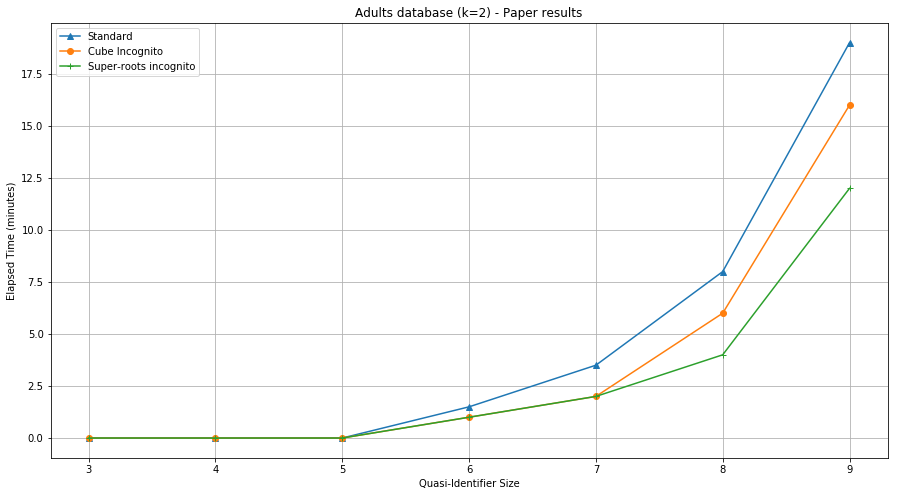

In [78]:
paper_data_x = [3,4,5,6,7,8,9]
paper_data_superRoot_K_2 = [0,0,0,1,2,4,12]
paper_data_cube_K_2 = [0,0,0,1,2,6,16]
paper_data_standard_K_2 = [0,0,0,1.5,3.5,8, 19]

plt.figure(figsize=(15,8))
plt.grid()
plt.plot(paper_data_x, paper_data_standard_K_2, '^-', label='Standard')
plt.plot(paper_data_x, paper_data_cube_K_2, 'o-', label='Cube Incognito')
plt.plot(paper_data_x, paper_data_superRoot_K_2, '+-', label='Super-roots incognito')
plt.title("Adults database (k=2) - Paper results")
plt.ylabel("Elapsed Time (minutes)")
plt.xlabel("Quasi-Identifier Size")
plt.legend()

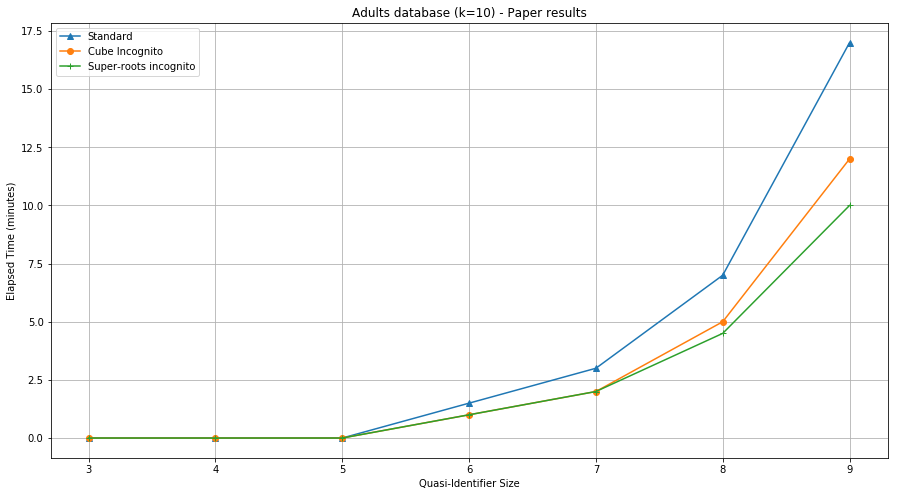

In [77]:
paper_data_x = [3,4,5,6,7,8,9]

paper_data_superRoot_K_10 = [0,0,0,1,2,4.5,10]
paper_data_cube_K_10 = [0,0,0,1,2,5,12]
paper_data_standard_K_10 = [0,0,0,1.5,3,7, 17]

plt.figure(figsize=(15,8))
plt.grid()
plt.plot(paper_data_x, paper_data_standard_K_10, '^-', label='Standard')
plt.plot(paper_data_x, paper_data_cube_K_10, 'o-', label='Cube Incognito')
plt.plot(paper_data_x, paper_data_superRoot_K_10, '+-', label='Super-roots incognito')
plt.title("Adults database (k=10) - Paper results")
plt.ylabel("Elapsed Time (minutes)")
plt.xlabel("Quasi-Identifier Size")
plt.legend()

In [68]:
def time_incognito(k, data, Q, dimensions, algorithm):
    stats = list()
    for i in range(3, len(Q)+1):
    #for i in range(3,4):
        tmpQ = Q[:i]
        start = time.time()
        algorithm(k, data, tmpQ, dimensions)
        end = time.time()
        stats.append(end-start)
    return stats    

Q = ['age', 'workclass', 'education', 'marital_status', 'occupation', 'race', 'gender', 'native_country', 'salary']        

our_data_standard_K_10 = time_incognito(10, data, Q, dimensions, incognito_standard)
print("standard done")
our_data_superRoot_K_10 = time_incognito(10, data, Q, dimensions, incognito_super_root)
print("superRoot done")
our_data_cube_K_10 = time_incognito(10, data, Q, dimensions, cube_incognito)
print("cube done")

our_data_standard_K_2 = time_incognito(2, data, Q, dimensions, incognito_standard)
print("standard done")
our_data_superRoot_K_2 = time_incognito(2, data, Q, dimensions, incognito_super_root)
print("superRoot done")
our_data_cube_K_2 = time_incognito(2, data, Q, dimensions, cube_incognito)
print("cube done")

standard done
superRoot done
cube done


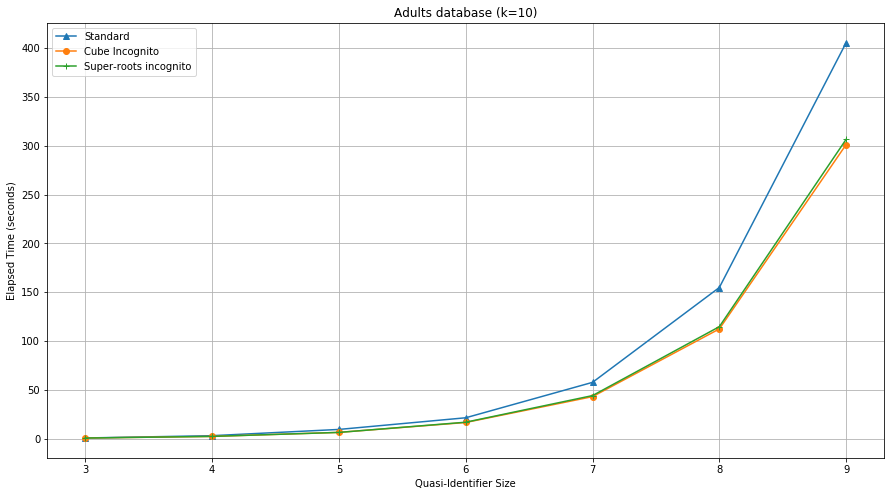

In [76]:
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(paper_data_x, our_data_standard_K_10, '^-', label='Standard')
plt.plot(paper_data_x, our_data_cube_K_10, 'o-', label='Cube Incognito')
plt.plot(paper_data_x, our_data_superRoot_K_10, '+-', label='Super-roots incognito')
plt.title("Adults database (k=10)")
plt.ylabel("Elapsed Time (seconds)")
plt.xlabel("Quasi-Identifier Size")
plt.legend()

In [71]:
print(our_data_standard_K_2)
print(our_data_superRoot_K_2)
print(our_data_cube_K_2)

[0.8181362152099609, 4.446078300476074, 17.06165623664856, 47.01350688934326, 134.4464099407196, 396.84931349754333, 1338.4568572044373]
[0.7896542549133301, 3.4080288410186768, 14.273719310760498, 41.35638213157654, 115.49333500862122, 338.89059114456177, 1164.8630907535553]
[0.8124485015869141, 3.427950859069824, 14.18666672706604, 40.978400230407715, 116.5875334739685, 339.9934618473053, 1161.175918340683]


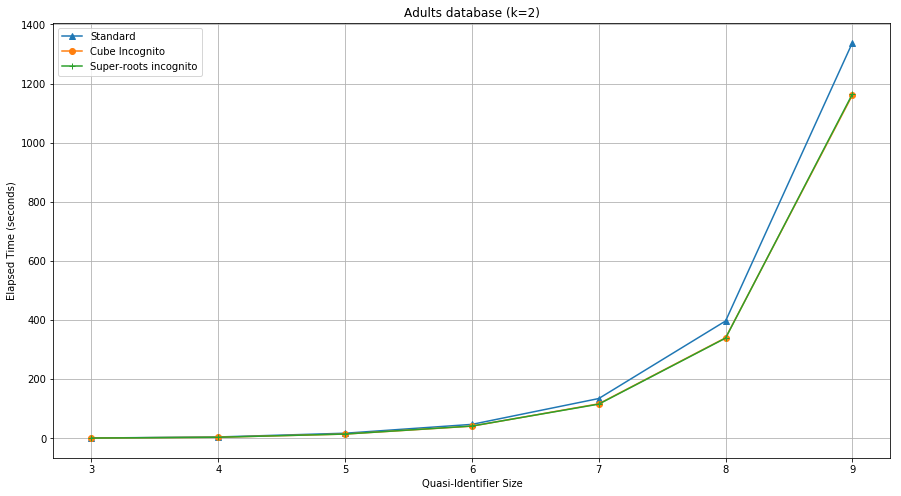

In [75]:
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(paper_data_x, our_data_standard_K_2, '^-', label='Standard')
plt.plot(paper_data_x, our_data_cube_K_2, 'o-', label='Cube Incognito')
plt.plot(paper_data_x, our_data_superRoot_K_2, '+-', label='Super-roots incognito')
plt.title("Adults database (k=2)")
plt.ylabel("Elapsed Time (seconds)")
plt.xlabel("Quasi-Identifier Size")
plt.legend()

In [70]:
print(our_data_standard_K_10)
print(our_data_superRoot_K_10)
print(our_data_cube_K_10)

[0.6154472827911377, 2.972156286239624, 9.371127367019653, 21.31086540222168, 57.597763776779175, 154.7722954750061, 405.57569670677185]
[0.559863805770874, 2.2343196868896484, 6.319512367248535, 16.767500638961792, 44.04072141647339, 114.63340544700623, 306.608824968338]
[0.5680036544799805, 2.213423728942871, 6.3404271602630615, 16.47464370727539, 42.95892310142517, 112.33826088905334, 301.22197365760803]
